In [24]:
import pandas as pd
import numpy as np
import re
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import datetime

def read_data(local=False, offset=0):
    if not local:
        print("read database!!!")
        df = pd.read_sql(f'SELECT * FROM crypt where id >{offset}', con=engine)
        df.to_csv("data.csv")
    else:
        print("read local df")
        df = pd.read_csv("data.csv", index_col=0)
    start = df.iloc[0]["time"]
    end = df.iloc[-1]["time"]
    return df, start, end

def cut_data(df, n):
    try:
        start = re.sub(":\d\d:", ":00:", str(df.index[0]))
        bins = pd.date_range(start, df.index[-1], freq=f'{n}Min')
        dti = pd.DatetimeIndex([bins[-1] + datetime.timedelta(minutes=n)])
        bins = bins.append(dti)
        cats = pd.cut(pd.to_datetime(df.index), bins=bins, labels=bins[:-1], right=False)
        df["cats"] = cats
        df1 = df.groupby(["cats"]).apply(lambda i: i.iloc[-1] if len(i) > 0 else None)
        df1.fillna(method='bfill', inplace=True)
        df1.index = cats.categories
        df1.drop('cats', axis=1, inplace=True)
        return df1
    except Exception as e:
        df.to_csv("fuck.csv")
        print(df.head(5))
        print(df.tail(5))
        print(f"cut data {n}",start,df.index[-1])
        print(repr(e))
def similarity(df, name):
    col = df[name]
    # t = df.drop(["time"], axis=1)
    # t.columns
    sims = df.values * col.values.reshape([-1, 1])
    similar = pd.Series(data=np.round(np.sum(sims, axis=0) / df.shape[0], 2), index=df.columns)
    return similar
def simi_filter(tdata, cs, n):
    """
    :param tdata: normalized data
    :param cs: ordered by similarity
    :param n: max n
    :return:
    """
#     plt.figure(figsize=(16, 9))
    index = cs.index

    # plt.scatter(x, tdata['CHR'], label="CHR")
    # plt.plot(x, tdata['CHR'])
    needed = []
    for i, C in enumerate(cs):
        if C < 0.3:
            continue
        needed.append(index[i])
        if i > n:
            break
    return tdata.loc[:,needed]


In [2]:
df = pd.read_csv("data.csv",index_col=0)

In [3]:
df3 = cut_data(df,3)

In [4]:
df3.head()

,ALICE,BTC,ADA,BNB,QTUM,SUSHI,SHIB,XTZ,ALGO,CHR,...,DOT,LINK,ZEN,NEAR,SOL,AUDIO,BTT,ALPHA,RAY,FTM
2021-09-11 16:00:00,12.52,45236.4,2.383,399.9,12.467,11.138,0.000006,7.836,2.1506,0.3321,...,28.63,26.57,79.97,8.933,177.63,2.217,0.003892,1.0992,15.399,1.4769
2021-09-11 16:03:00,12.52,45236.4,2.383,399.9,12.467,11.138,0.000006,7.836,2.1506,0.3321,...,28.63,26.57,79.97,8.933,177.63,2.217,0.003892,1.0992,15.399,1.4769
2021-09-11 16:06:00,12.52,45236.4,2.383,399.9,12.467,11.138,0.000006,7.836,2.1506,0.3321,...,28.63,26.57,79.97,8.933,177.63,2.217,0.003892,1.0992,15.399,1.4769
2021-09-11 16:09:00,12.52,45236.4,2.383,399.9,12.467,11.138,0.000006,7.836,2.1506,0.3321,...,28.63,26.57,79.97,8.933,177.63,2.217,0.003892,1.0992,15.399,1.4769
2021-09-11 16:12:00,12.52,45236.4,2.383,399.9,12.467,11.138,0.000006,7.836,2.1506,0.3321,...,28.63,26.57,79.97,8.933,177.63,2.217,0.003892,1.0992,15.399,1.4769


In [6]:
df3.shape

(1916, 31)

In [7]:
data = df3.tail(30)

In [10]:
from sklearn.preprocessing import StandardScaler

scale = StandardScaler()



In [11]:
t = scale.fit_transform(data)
tdata = pd.DataFrame(data=t, columns=data.columns)


<AxesSubplot:>

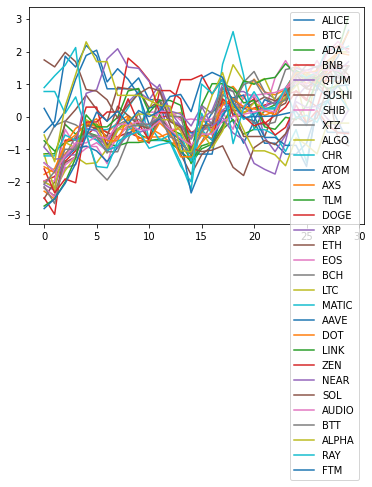

In [12]:
tdata.plot()

In [20]:
sim = similarity(tdata,"ALICE")


In [29]:

sortedsim = sim.sort_values(ascending=False)
print(sortedsim)

fdf = simi_filter(tdata,sortedsim,3)
fdf.head()

ALICE    1.00
AAVE     0.80
ALPHA    0.75
SOL      0.62
NEAR     0.38
SUSHI    0.27
CHR      0.18
RAY     -0.07
DOGE    -0.09
LINK    -0.14
ZEN     -0.15
ADA     -0.18
QTUM    -0.19
LTC     -0.21
DOT     -0.23
BTC     -0.24
ETH     -0.26
AXS     -0.27
BCH     -0.30
MATIC   -0.32
BTT     -0.33
FTM     -0.33
AUDIO   -0.36
SHIB    -0.38
BNB     -0.38
TLM     -0.40
XRP     -0.41
XTZ     -0.41
ATOM    -0.48
EOS     -0.49
ALGO    -0.49
dtype: float64


,ALICE,AAVE,ALPHA,SOL,NEAR
0,-0.478339,0.256846,-0.560482,1.742990,-0.939179
1,-0.144614,-0.310919,-1.381440,1.529449,-1.303673
2,1.857736,0.175737,0.321289,1.975100,-1.267224
3,1.524011,1.149047,1.294277,1.687284,-0.902730
4,2.191461,1.879030,2.297671,0.833120,0.719268


<AxesSubplot:>

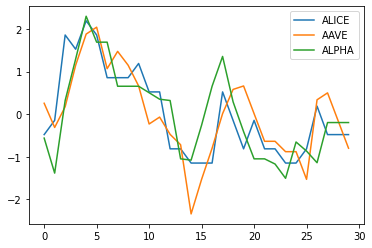

In [33]:
fdf.iloc[:,:3].plot()